# Visualize your Google location history 

See [this blog post](http://geoffboeing.com/2016/06/mapping-google-location-history-python/) for my write-up of this project.

Visit https://accounts.google.com/ServiceLogin?service=backup to download your Google location history as a JSON file called `LocationHistory.json`

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime as dt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
# load the google location history data
df_gps = pd.read_json('data/LocationHistory.json')
print('There are {:,} rows in the location history dataset'.format(len(df_gps)))

There are 1,574,479 rows in the location history dataset


In [3]:
# parse lat, lon, and timestamp from the dict inside the locations column
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp_ms'] = df_gps['locations'].map(lambda x: x['timestampMs'])

# convert lat/lon to decimalized degrees and the timestamp to date-time
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7
df_gps['timestamp_ms'] = df_gps['timestamp_ms'].astype(float) / 1000
df_gps['datetime'] = df_gps['timestamp_ms'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
date_range = '{}-{}'.format(df_gps['datetime'].min()[:4], df_gps['datetime'].max()[:4])

In [4]:
# drop columns we don't need, then show a slice of the dataframe
df_gps = df_gps.drop(labels=['locations', 'timestamp_ms'], axis=1, inplace=False)
#df_gps[1000:1005]

## Now map the entire dataset (approx 1.6 million points)

In [5]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

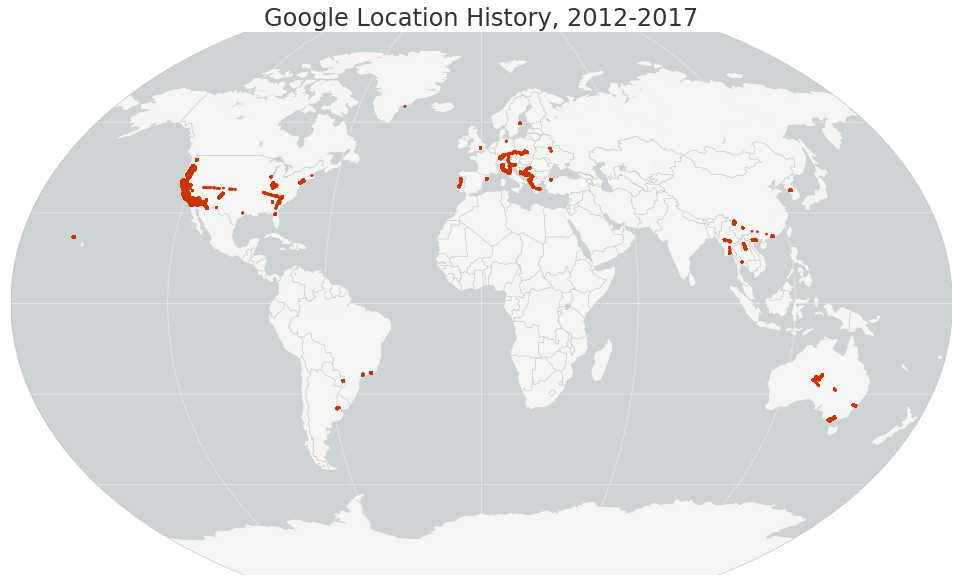

In [6]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Google Location History, {}'.format(date_range), fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project the location history points then scatter plot them
x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('images/google_location_history_world_map.png', dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Now map just California

In [7]:
# first define a transverse mercator projection for california
map_width_m = 1000 * 1000
map_height_m = 1200 * 1000
target_crs = {'datum':'WGS84',
              'ellps':'WGS84',
              'proj':'tmerc',
              'lon_0':-119,
              'lat_0':37.5}

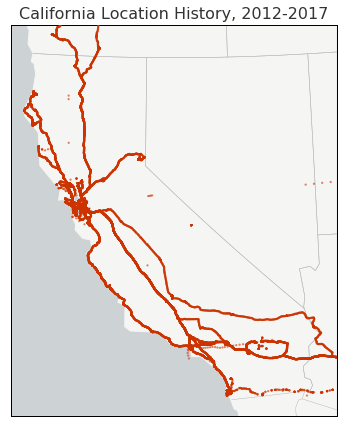

In [8]:
# plot the map
fig_width = 6
fig = plt.figure(figsize=[fig_width, fig_width * map_height_m / float(map_width_m)])
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('California Location History, {}'.format(date_range), fontsize=16, color='#333333')

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='l',
            area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=5, color=marker_fill_color, edgecolor=marker_edge_color, alpha=0.6, zorder=3)

plt.savefig('images/google_location_history_cal_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Now map just the San Francisco Bay Area

In [9]:
# first define a transverse mercator projection centered on the bay area
map_width_m = 100 * 1000
map_height_m = 120 * 1000
target_crs = {'datum':'WGS84',
              'ellps':'WGS84',
              'proj':'tmerc',
              'lon_0':-122.3,
              'lat_0':37.8}

# define how the annotations should look
color = 'k'
weight = 'black'
size = 12
alpha = 0.3
xycoords = 'axes fraction'

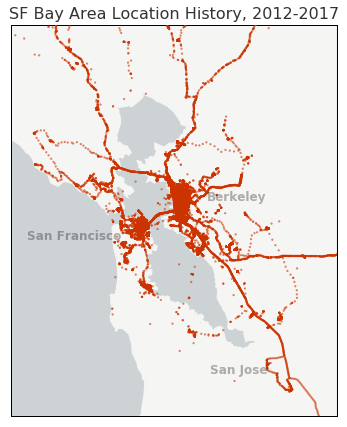

In [10]:
# plot the map
fig_width = 6
fig = plt.figure(figsize=[fig_width, fig_width * map_height_m / float(map_width_m)])
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('SF Bay Area Location History, {}'.format(date_range), fontsize=16, color='#333333')

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='h',
            area_thresh=10)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=5, color=marker_fill_color, edgecolor=marker_edge_color, alpha=0.6, zorder=3)

# annotate some cities in the bay area
plt.annotate('San Francisco', xy=(0.05, 0.45), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)
plt.annotate('Berkeley', xy=(0.60, 0.55), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)
plt.annotate('San Jose', xy=(0.61, 0.11), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)

plt.savefig('images/google_location_history_sf_bay_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()